In [1]:
import pickle
import random

import dill
import numpy as np
import matplotlib.pyplot as plt
import torch
from botorch import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.utils.transforms import normalize
from gpytorch import ExactMarginalLogLikelihood

from gen_sim import combine_sos, gen_sim

torch.set_default_device('cuda')
torch.set_default_dtype(torch.double)

In [160]:
def plot_ground_truth(sim, param_range, orientation='vertical'):
    x = np.linspace(0, 500, 100)
    y = np.linspace(0, 200, 100)
    X, Y = np.meshgrid(x, y)
    surface = np.zeros(X.shape)
    for i in range(surface.shape[0]):
        for j in range(surface.shape[1]):
            surface[i][j] = (combine_sos(sim, {'amp': x[i], 'pw': y[j]}, param_range)) / sim['scale'] * sim['mean_effect'] / sim['std_effect']
    
    ax = plt.gca()
    CS = ax.contourf(X.transpose(), Y.transpose(), surface, 100, cmap='RdBu_r', vmin=-np.max(abs(surface)),
                     vmax=np.max(abs(surface)))
    plt.plot(x, (x - sim['saf_h']) ** 2 / sim['saf_a'] + sim['saf_k'], color='black')
    cbar = plt.gcf().colorbar(CS, ax=ax, orientation=orientation)
    plt.ylabel('Pulse Width ($\\mu$s)')
    plt.xlabel('Amplitude ($\\mu$A)')
    plt.ylim([0, 200])
    cbar.set_label('Stim Effect')
    return cbar

In [172]:
def posterior_plot(ax, bounds, mdl, x_data, y_data, num_steps=100, scatter=True, std=False, alpha=True, edge=False, orientation='vertical'):  # Show plot in separate thread?
    grid_x, grid_y = np.meshgrid(np.linspace(0, 1, num_steps), np.linspace(0, 1, num_steps), indexing='ij')
    values = np.concatenate([grid_x.reshape(-1, 1), grid_y.reshape(-1, 1)], axis=1)
    grid_x = grid_x * (bounds[1][0] - bounds[0][0]) + bounds[0][0]
    grid_y = grid_y * (bounds[1][1] - bounds[0][1]) + bounds[0][1]
    if std:
        post = mdl.posterior(torch.tensor(values, device='cuda', dtype=torch.double),
                             observation_noise=False).variance.detach().cpu().numpy()
        CS = ax.contourf(grid_x, grid_y, post.reshape((num_steps, num_steps)), 20)
    else:
        post = mdl.posterior(torch.tensor(values, device='cuda', dtype=torch.double),
                             observation_noise=False).mean.detach().cpu().numpy()
        CS = ax.contourf(grid_x, grid_y, post.reshape((num_steps, num_steps)), 20, cmap='RdBu_r', vmin=-np.max(abs(post)), vmax=np.max(abs(post)))
    if scatter:
        x_d = x_data.cpu()
        ax.scatter(x_d[:, 0] * (bounds[1][0] - bounds[0][0]) + bounds[0][0],
                   x_d[:, 1] * (bounds[1][1] - bounds[0][1]) + bounds[0][1], c=y_data.cpu(),
                   edgecolors='white' if edge else 'none', norm=CS.norm, cmap='RdBu_r', alpha=0.3 if alpha else 1)
    cbar = plt.colorbar(CS, ax=ax, orientation=orientation)
    plt.ylabel('Pulse Width ($\\mu$s)')
    plt.xlabel('Amplitude ($\\mu$A)')
    if not std:
        cbar.set_label('Estimated Stim Effect')
    else:
        cbar.set_label('Posterior Variance')
    return cbar

In [2]:
def get_sample(sim, params, param_range):
    return (combine_sos(sim, params, param_range) / sim['scale'] * sim['mean_effect'] + np.random.normal(0, sim['std_effect'])) / sim['std_effect']

In [3]:
param_range = {'amp': (0, 500), 'pw': (0, 200)}

Generate simulations

In [3]:
param_range = {'amp': (0, 500), 'pw': (0, 200)}
sims = []
effect_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
for i in range(len(effect_sizes) * 20):
    sims.append(gen_sim([-effect_sizes[i % 6],1], param_range, safety=True))
with open('sims_100_01-06_2.pickle', 'wb') as handle:
    dill.dump(sims, handle, protocol=pickle.HIGHEST_PROTOCOL)

Run model on simulations

In [6]:
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
import math
import copy
from botorch.exceptions import BotorchWarning
import warnings
from botorch.utils.transforms import unnormalize
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound, qLowerBoundMaxValueEntropy, PosteriorStandardDeviation

warnings.simplefilter("ignore", BotorchWarning)

with open('sims_100_01-06.pickle', 'rb') as handle:
    sims = pickle.load(handle)

tkwargs = {"dtype": torch.double, "device": 'cuda'}
bounds = [(0, 0), (500, 200)]
tensor_bounds = torch.atleast_2d(torch.tensor(bounds, **tkwargs))
init_params = [[0, 150, 300, 300, 150, 0], [0, 0, 0, 50, 50, 50]]
standard_bounds = torch.zeros(2, 2, **tkwargs)
standard_bounds[1] = 1

n_session = 8
n_trial = 150

aq_name = 'pf_gibbon'

class EGProblem(Problem):
    def __init__(self, model, sim):
        super().__init__(n_var=2, n_obj=2, n_ieq_constr=1, xl=[0,0], xu=[1,1])
        self.model = model
        self.sim = sim
    
    def _evaluate(self, x, out, *args, **kwargs):
        t_x = torch.tensor(x)
        mu = self.model.posterior(t_x).mean
        var = self.model.posterior(t_x).variance
        out['F'] = torch.cat((mu, -var), dim=1).detach().cpu().numpy()
        out['G'] = x[:, 1] * 200 - ((x[:, 0] * 500 - self.sim['saf_h']) ** 2 / self.sim['saf_a'] + self.sim['saf_k'])

algorithm = NSGA2(pop_size=60)

results = []
# Iterate over simulations
for n, sim in enumerate(sims):
    results.append({})
    results[-1]['hyperparams'] = []
    # Generate safety condition
    nonlinear_constraint = lambda x: ((x[0, 0] * 500 - sim['saf_h']) ** 2 / sim['saf_a'] + sim['saf_k']) - x[0, 1] * 200
    
    # Generate samples for initialization parameters
    params = copy.deepcopy(init_params)
    samples = []
    for i in range(len(init_params[0])):
        samples.append(get_sample(sim, {'amp': init_params[0][i], 'pw': init_params[1][i]}, param_range))
    x_data = torch.tensor(init_params, **tkwargs).transpose(0, 1)
    y_data = torch.unsqueeze(torch.tensor(samples, **tkwargs), dim=-1)
    
    # Fit the GP model
    results[-1]['model'] = SingleTaskGP(normalize(x_data, tensor_bounds), y_data, torch.ones_like(y_data))
    results[-1]['model'].mean_module.initialize(constant=0)
    results[-1]['model'].mean_module.raw_constant.requires_grad = False
    mll = ExactMarginalLogLikelihood(results[-1]['model'].likelihood, results[-1]['model'])
    fit_gpytorch_mll(mll)
    results[-1]['hyperparams'].append(copy.deepcopy(results[-1]['model'].state_dict()))
    
    # Run n_session sessions of n_trial trials
    for i in range(n_trial * n_session):
        # Find the best safe initial conditions
        init_conds = torch.rand((1000, 2), **tkwargs)
        valid = ((init_conds[:, 0] * 500 - sim['saf_h']) ** 2 / sim['saf_a'] + sim['saf_k']) > init_conds[:, 1] * 200
        init_conds = init_conds[valid, :]
        if aq_name != 'eg' and ('pf_gibbon' not in aq_name or random.random() > 0.7):
            if aq_name == 'gibbon' or 'pf_gibbon' in aq_name:
                candidate_set = torch.rand(100, tensor_bounds.size(1), **tkwargs)
                acq_func = qLowerBoundMaxValueEntropy(results[-1]['model'], candidate_set, maximize=False)
            elif aq_name == 'ucb':
                d = 0.01
                t = len(init_params[0]) + i
                beta = 2 * np.log(t ** 3 * math.pi ** 2 / (3 * d))
                acq_func = UpperConfidenceBound(results[-1]['model'], beta=beta, maximize=False)
            elif aq_name == 'std':
                acq_func = PosteriorStandardDeviation(results[-1]['model'])
            
            vals = acq_func(torch.unsqueeze(init_conds, dim=1))
            sI = torch.argsort(vals, descending=True)
            
            # Optimize the acquisition function with the safety condition
            candidates, val = optimize_acqf(
                acq_function=acq_func,
                bounds=standard_bounds,
                q=1,
                num_restarts=10,
                raw_samples=512,
                sequential=False,
                nonlinear_inequality_constraints=[(nonlinear_constraint, False)],
                batch_initial_conditions=torch.unsqueeze(init_conds[sI[:10], :], dim=1),
            )
            candidate = unnormalize(candidates, tensor_bounds)
        else:
            epsilon = 0.9
            res = minimize(EGProblem(results[-1]['model'], sim),
               algorithm,
               seed=1,
               termination=('n_gen', 30))
            if random.random() < epsilon or 'pf_gibbon' in aq_name:
                candidate = np.expand_dims(res.X[random.randint(0, res.X.shape[0] - 1)], axis=0)
            else:
                candidate = np.expand_dims(res.X[torch.argmin(res.F[:, :0]), :], axis=0)
            candidate[:, 0] *= 500
            candidate[:, 1] *= 200
        
        # Update model with new sample
        params[0].append(candidate[0, 0].item())
        params[1].append(candidate[0, 1].item())
        samples.append(get_sample(sim, {'amp': params[0][-1], 'pw': params[1][-1]}, param_range))
        x_data = torch.tensor(params, **tkwargs).transpose(0, 1)
        y_data = torch.unsqueeze(torch.tensor(samples, **tkwargs), dim=-1)
        results[-1]['model'] = SingleTaskGP(normalize(x_data, tensor_bounds), y_data, torch.ones_like(y_data))
        results[-1]['model'].mean_module.initialize(constant=0)
        results[-1]['model'].mean_module.raw_constant.requires_grad = False
        
        # Reoptimize hyperparameters after each session
        if i % n_trial == n_trial - 1:
            # fig = plt.figure(figsize=(12, 6))
            # ax = fig.add_subplot(121)
            # posterior_plot(ax, bounds, results[-1]['model'], results[-1]['model'].train_inputs[0], results[-1]['model'].train_targets)
            # ax2 = fig.add_subplot(122)
            # posterior_plot(ax2, bounds, results[-1]['model'], results[-1]['model'].train_inputs[0], results[-1]['model'].train_targets, std=True, scatter=False)
            # plt.show()
            mll = ExactMarginalLogLikelihood(results[-1]['model'].likelihood, results[-1]['model'])
            fit_gpytorch_mll(mll)
            results[-1]['hyperparams'].append(copy.deepcopy(results[-1]['model'].state_dict()))
            print(f'{n}_{i}')

with open(f'outcomes/outcomes_{aq_name}_2.pickle', 'wb') as handle:
    dill.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

0_149
0_299
0_449
0_599
0_749
0_899
0_1049
0_1199
1_149
1_299
1_449
1_599
1_749
1_899
1_1049
1_1199
2_149
2_299
2_449
2_599
2_749
2_899
2_1049
2_1199
3_149
3_299
3_449
3_599
3_749
3_899
3_1049
3_1199
4_149
4_299
4_449
4_599
4_749
4_899
4_1049
4_1199
5_149
5_299
5_449
5_599
5_749
5_899
5_1049
5_1199
6_149
6_299
6_449
6_599
6_749
6_899
6_1049
6_1199
7_149
7_299
7_449
7_599
7_749
7_899
7_1049
7_1199
8_149
8_299
8_449
8_599
8_749
8_899
8_1049
8_1199
9_149
9_299
9_449
9_599
9_749
9_899
9_1049
9_1199
10_149
10_299
10_449
10_599
10_749
10_899
10_1049
10_1199
11_149
11_299
11_449
11_599
11_749
11_899
11_1049
11_1199
12_149
12_299
12_449
12_599
12_749
12_899
12_1049
12_1199
13_149
13_299
13_449
13_599
13_749
13_899
13_1049
13_1199
14_149
14_299
14_449
14_599
14_749
14_899
14_1049
14_1199
15_149
15_299
15_449
15_599
15_749
58_149
58_299
58_449
58_599
58_749
58_899
58_1049
58_1199
59_149
59_299
59_449
59_599
59_749
59_899
59_1049
59_1199
60_149
60_299
60_449
60_599
60_749
60_899
60_1049
60_1199
6

C:\Users\Optimization\Documents\GitHub\NeuroOptimizationPaper\gen_sim.py:45: RuntimeWarning: divide by zero encountered in scalar power
  value /= (1 + (D ** off_offset / (1 - D - off_shift) ** off_offset) ** (-off_scale))


62_149
62_299
62_449
62_599
62_749
62_899
62_1049
62_1199
63_149
63_299
63_449
63_599
63_749
63_899
63_1049
63_1199
64_149
64_299
64_449
64_599
64_749
64_899
64_1049
64_1199
65_149
65_299
65_449
65_599
65_749
65_899
65_1049
65_1199
66_149
66_299
66_449
66_599
66_749
66_899
66_1049
66_1199
67_149
67_299
67_449
67_599
67_749
67_899
67_1049
67_1199
68_149
68_299
68_449
68_599
68_749
68_899
68_1049
68_1199
69_149
69_299
69_449
69_599
69_749
69_899
69_1049
69_1199
70_149
70_299
70_449
70_599
70_749
70_899
70_1049
70_1199
71_149
71_299
71_449
71_599
71_749
71_899
71_1049
71_1199
72_149
72_299
72_449
72_599
72_749
72_899
72_1049
72_1199
73_149
73_299
73_449
73_599
73_749
73_899
73_1049
73_1199
74_149
74_299
74_449
74_599
74_749
74_899
74_1049
74_1199
75_149
75_299
75_449
75_599
75_749
75_899
75_1049
75_1199
76_149
76_299
76_449
76_599
76_749
76_899
76_1049
76_1199
77_149
77_299
77_449
77_599
77_749
77_899
77_1049
77_1199
78_149
78_299
78_449
78_599
78_749
78_899
78_1049
78_1199
79_149
79_299


In [31]:
from botorch.exceptions import BotorchWarning
import warnings
from botorch.optim import optimize_acqf

aq_name = 'gibbon'
with open('sims_100_01-06_2.pickle', 'rb') as handle:
    sims = pickle.load(handle)
with open(f'outcomes/outcomes_{aq_name}_2.pickle', 'rb') as handle:
    results = pickle.load(handle)

tkwargs = {"dtype": torch.double, "device": 'cuda'}
bounds = [(0, 0), (500, 200)]
tensor_bounds = torch.atleast_2d(torch.tensor(bounds, **tkwargs))
init_params = [[0, 150, 300, 300, 150, 0], [0, 0, 0, 50, 50, 50]]
standard_bounds = torch.zeros(2, 2, **tkwargs)
standard_bounds[1] = 1
n_session = 8
n_trial = 150
warnings.simplefilter("ignore", BotorchWarning)

In [7]:
from botorch.acquisition import PosteriorMean

performance = []
i = 0
for outcome, sim in zip(results, sims):
    nonlinear_constraint = lambda x: ((x[0, 0] * 500 - sim['saf_h']) ** 2 / sim['saf_a'] + sim['saf_k']) - x[0, 1] * 200
    performance.append([])
    for j in range(8):
        model = SingleTaskGP(outcome['model'].train_inputs[0][:(j+1)*n_trial+6,:], torch.unsqueeze(outcome['model'].train_targets[:(j+1)*n_trial+6], dim=1), torch.ones(((j+1)*n_trial+6), 1))
        model.load_state_dict(outcome['hyperparams'][j])
        acqf = PosteriorMean(model, maximize=False)
        
        init_conds = torch.rand((1000, 2), **tkwargs)
        valid = ((init_conds[:, 0] * 500 - sim['saf_h']) ** 2 / sim['saf_a'] + sim['saf_k']) > init_conds[:, 1] * 200
        init_conds = init_conds[valid, :]
        vals = acqf(torch.unsqueeze(init_conds, dim=1))
        sI = torch.argsort(vals)
        
        opt = optimize_acqf(
            acq_function=acqf,
            bounds=standard_bounds,
            q=1,
            raw_samples=512,
            num_restarts=10,
            nonlinear_inequality_constraints=[(nonlinear_constraint, False)],
            batch_initial_conditions=torch.unsqueeze(init_conds[sI[:10], :], dim=1),
        )
        opt_loc = opt[0].detach().cpu().numpy()
        performance[-1].append(combine_sos(sim, {'amp': opt_loc[0, 0] * 500, 'pw': opt_loc[0, 1] * 200}, sim['param_ranges']) / sim['scale'])
        print(str(i) + ' ' + str(j))
    i += 1
with open(f'outcomes/performance_{aq_name}_2.pickle', 'wb') as handle:
    pickle.dump(performance, handle, protocol=pickle.HIGHEST_PROTOCOL)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
21 0
21 1
21 2
21 3
21 4
21 5
21 6
21 7
22 0
22 1
22 2
22 3
22 4
22 5
22 6
22 7
23 0
23 1
23 2
23 3
23 4
23 5
23 6
23 7
24 0
24 1
24 2
24 3
24 4
24 5
24 6
24 7
25 0
25 1
25 2
25 3
25 4
25 5
25 6
25 7
26 0
26 1
26 2
26 3
26 4
26 5
26 6
26 7


In [18]:
performance = []
i = 0
for sim in sims:
    nonlinear_constraint = lambda x: ((x[0] * 500 - sim['saf_h']) ** 2 / sim['saf_a'] + sim['saf_k']) - x[1] * 200
    performance.append([])
    for j in range(8):
        opt_loc = [random.random(), random.random()]
        while nonlinear_constraint(opt_loc) < 0:
            opt_loc = [random.random(), random.random()]
        performance[-1].append(combine_sos(sim, {'amp': opt_loc[0] * 500, 'pw': opt_loc[1] * 200}, sim['param_ranges']) / sim['scale'])
        print(str(i) + ' ' + str(j))
    i += 1
with open(f'outcomes/performance_random_2.pickle', 'wb') as handle:
    pickle.dump(performance, handle, protocol=pickle.HIGHEST_PROTOCOL)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
21 0
21 1
21 2
21 3
21 4
21 5
21 6
21 7
22 0
22 1
22 2
22 3
22 4
22 5
22 6
22 7
23 0
23 1
23 2
23 3
23 4
23 5
23 6
23 7
24 0
24 1
24 2
24 3
24 4
24 5
24 6
24 7
25 0
25 1
25 2
25 3
25 4
25 5
25 6
25 7
26 0
26 1
26 2
26 3
26 4
26 5
26 6
26 7


([<matplotlib.axis.XTick at 0x24ed33393f0>,
 [Text(0.1, 0, '0.1'),
  Text(0.2, 0, '0.2'),
  Text(0.3, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6, 0, '0.6')])

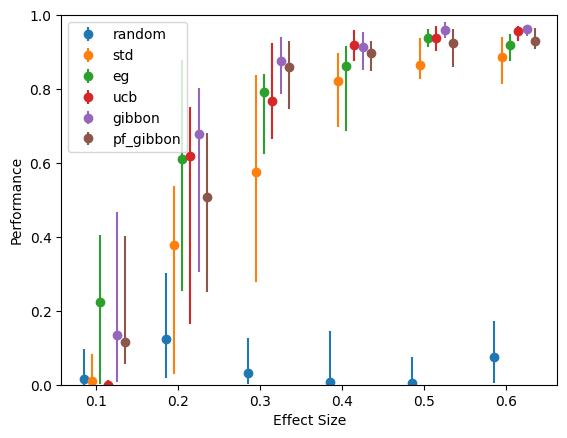

In [9]:
import os
from scipy.stats import bootstrap

acqfs = ['random', 'std', 'eg', 'ucb', 'gibbon', 'pf_gibbon']
effect_sizes = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
fig = plt.figure()
for i, acq in enumerate(acqfs):
    with open(f'outcomes/performance_{acq}.pickle', 'rb') as handle:
        performance = pickle.load(handle)
    j = 2
    perf_mat = np.asarray(performance)
    while os.path.isfile(f'outcomes/performance_{acq}_{j}.pickle'):
        with open(f'outcomes/performance_{acq}_{j}.pickle', 'rb') as handle:
            perf_mat = np.concatenate((perf_mat, np.asarray(pickle.load(handle))), axis=0)
        j += 1
    conditions = perf_mat[:,-1].reshape((int(perf_mat.shape[0]/6), 6))
    m_c = np.median(conditions, axis=0)
    l_c = np.zeros_like(m_c)
    h_c = np.zeros_like(m_c)
    for j in range(conditions.shape[1]):
        res = bootstrap((conditions[:,j],), np.median, n_resamples=1000)
        l_c[j] = res.confidence_interval.low
        h_c[j] = res.confidence_interval.high
    plt.errorbar(effect_sizes + (i - 2) * 0.01 + 0.005, m_c, yerr=(m_c-l_c, h_c-m_c), linestyle='none', marker='o')
plt.legend(acqfs, loc='upper left')
plt.xlabel('Effect Size')
plt.ylabel('Performance')
plt.ylim(0, 1)
plt.yticks([0,0.2,0.4,0.6,0.8,1])
plt.xticks(effect_sizes)

([<matplotlib.axis.YTick at 0x24ed334c6d0>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

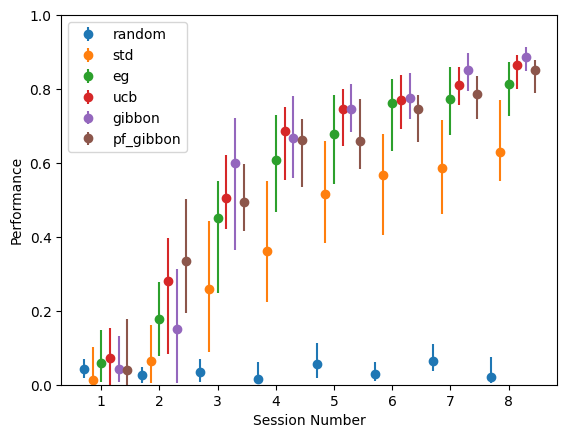

In [10]:
from scipy.stats import bootstrap

acqfs = ['random', 'std', 'eg', 'ucb', 'gibbon', 'pf_gibbon']
effect_sizes = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
fig = plt.figure()
for i, acq in enumerate(acqfs):
    with open(f'outcomes/performance_{acq}.pickle', 'rb') as handle:
        performance = pickle.load(handle)
    perf_mat = np.asarray(performance)
    j = 2
    while os.path.isfile(f'outcomes/performance_{acq}_{j}.pickle'):
        with open(f'outcomes/performance_{acq}_{j}.pickle', 'rb') as handle:
            perf_mat = np.concatenate((perf_mat, np.asarray(pickle.load(handle))), axis=0)
        j += 1
    m_c = np.median(perf_mat, axis=0)
    l_c = np.zeros_like(m_c)
    h_c = np.zeros_like(m_c)
    for j in range(perf_mat.shape[1]):
        res = bootstrap((perf_mat[:,j],), np.median, n_resamples=1000)
        l_c[j] = res.confidence_interval.low
        h_c[j] = res.confidence_interval.high
    plt.errorbar(np.arange(1,9) + (i - 2) * 0.15, m_c, yerr=(m_c - l_c, h_c-m_c), linestyle='none', marker='o')
plt.legend(acqfs, loc='upper left')
plt.xlabel('Session Number')
plt.ylabel('Performance')
plt.xticks(np.arange(1,9))
plt.ylim(0, 1)
plt.yticks([0,0.2,0.4,0.6,0.8,1])

C:\Users\Optimization\AppData\Local\anaconda3\envs\NeuroOptimizationPaper\lib\site-packages\scipy\stats\_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\Optimization\AppData\Local\Temp\ipykernel_31712\2144978845.py:30: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  res = bootstrap((n_boundary_samples[:,j],), np.median, n_resamples=1000)


([<matplotlib.axis.YTick at 0x24ed2c2c2b0>,
 [Text(0, 0, '0'), Text(0, 25, '25'), Text(0, 50, '50'), Text(0, 75, '75')])

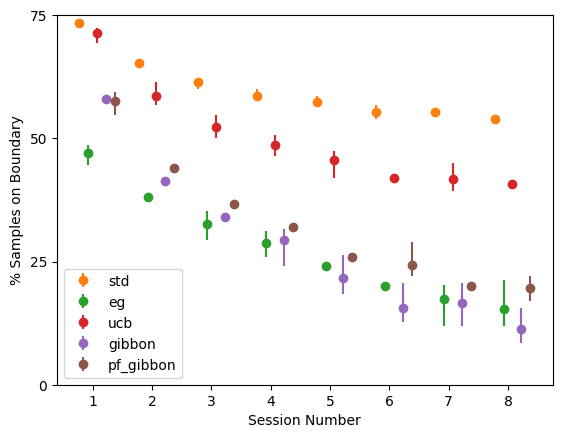

In [11]:
acqfs = ['std', 'eg', 'ucb', 'gibbon', 'pf_gibbon']
n_session = 8
n_trial = 150
fig = plt.figure()
plt.gca()._get_lines.get_next_color()
sims_full = []
with open('sims_100_01-06.pickle', 'rb') as handle:
    sims_full += pickle.load(handle)
with open('sims_100_01-06_2.pickle', 'rb') as handle:
    sims_full += pickle.load(handle)
for i, acq in enumerate(acqfs):
    with open(f'outcomes/outcomes_{acq}.pickle', 'rb') as handle:
        results = pickle.load(handle)
    j = 2
    while os.path.isfile(f'outcomes/outcomes_{acq}_{j}.pickle'):
        with open(f'outcomes/outcomes_{acq}_{j}.pickle', 'rb') as handle:
            results += pickle.load(handle)
        j += 1
    n_boundary_samples = np.zeros((len(results), 8))
    for j, (sim, res) in enumerate(zip(sims_full, results)):
        input = res['model'].train_inputs[0][6:,:]
        on_boundary = torch.any(input < 0.025, dim=1)
        on_boundary |= torch.abs(((input[:, 0] * 500 - sim['saf_h']) ** 2 / sim['saf_a'] + sim['saf_k']) - 200 * input[:, 1]) < 0.025
        boundary_mat = torch.reshape(on_boundary, (n_session, n_trial))
        n_boundary_samples[j, :] = torch.sum(boundary_mat, dim=1).detach().cpu().numpy() / n_trial * 100
    m_c = np.median(n_boundary_samples, axis=0)
    l_c = np.zeros_like(m_c)
    h_c = np.zeros_like(m_c)
    for j in range(n_boundary_samples.shape[1]):
        res = bootstrap((n_boundary_samples[:,j],), np.median, n_resamples=1000)
        l_c[j] = res.confidence_interval.low
        h_c[j] = res.confidence_interval.high
    plt.errorbar(np.arange(1,9) + (i - 2) * 0.15 + 0.075, m_c, yerr=(m_c - l_c, h_c-m_c), linestyle='none', marker='o')
plt.legend(acqfs, loc='lower left')
plt.xlabel('Session Number')
plt.ylabel('% Samples on Boundary')
plt.xticks(np.arange(1,9))
plt.ylim(0, 75)
plt.yticks([0,25,50,75])

C:\Users\Optimization\AppData\Local\Temp\ipykernel_31712\1984829229.py:36: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  res = bootstrap((n_boundary_samples[:,j],), np.median, n_resamples=1000)


([<matplotlib.axis.XTick at 0x24b0f36a5c0>,
 [Text(0.1, 0, '0.1'),
  Text(0.2, 0, '0.2'),
  Text(0.3, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6, 0, '0.6')])

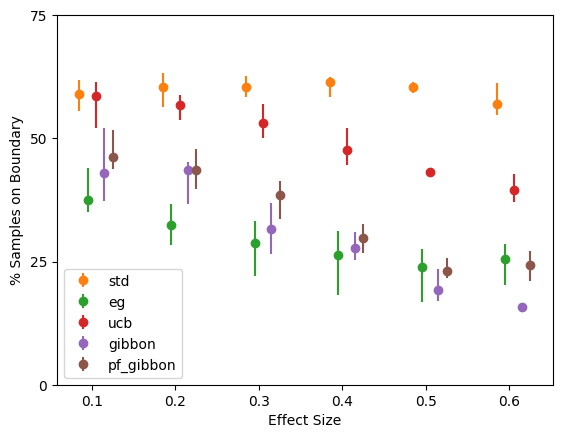

In [12]:
acqfs = ['std', 'eg', 'ucb', 'gibbon', 'pf_gibbon']
effect_sizes = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
fig = plt.figure()
plt.gca()._get_lines.get_next_color()
sims_full = []
with open('sims_100_01-06.pickle', 'rb') as handle:
    sims_full += pickle.load(handle)
with open('sims_100_01-06_2.pickle', 'rb') as handle:
    sims_full += pickle.load(handle)
for i, acq in enumerate(acqfs):
    with open(f'outcomes/outcomes_{acq}.pickle', 'rb') as handle:
        results = pickle.load(handle)
    j = 2
    while os.path.isfile(f'outcomes/outcomes_{acq}_{j}.pickle'):
        with open(f'outcomes/outcomes_{acq}_{j}.pickle', 'rb') as handle:
            results += pickle.load(handle)
        j += 1
    with open(f'outcomes/performance_{acq}.pickle', 'rb') as handle:
        performance = pickle.load(handle)
    j = 2
    perf_mat = np.asarray(performance)
    while os.path.isfile(f'outcomes/performance_{acq}_{j}.pickle'):
        with open(f'outcomes/performance_{acq}_{j}.pickle', 'rb') as handle:
            perf_mat = np.concatenate((perf_mat, np.asarray(pickle.load(handle))), axis=0)
        j += 1
    n_boundary_samples = np.zeros((len(results) // len(effect_sizes), len(effect_sizes)))
    for j, (sim, res) in enumerate(zip(sims_full, results)):
        input = res['model'].train_inputs[0]
        on_boundary = torch.any(input < 0.025, dim=1)
        on_boundary |= torch.abs(((input[:, 0] * 500 - sim['saf_h']) ** 2 / sim['saf_a'] + sim['saf_k']) - 200 * input[:, 1]) < 0.025
        n_boundary_samples[j // len(effect_sizes), j % len(effect_sizes)] = torch.sum(on_boundary).detach().cpu().numpy() / on_boundary.shape[0] * 100
    m_c = np.median(n_boundary_samples, axis=0)
    l_c = np.zeros_like(m_c)
    h_c = np.zeros_like(m_c)
    for j in range(n_boundary_samples.shape[1]):
        res = bootstrap((n_boundary_samples[:,j],), np.median, n_resamples=1000)
        l_c[j] = res.confidence_interval.low
        h_c[j] = res.confidence_interval.high
    plt.errorbar(effect_sizes + (i - 2) * 0.01 + 0.005, m_c, yerr=(m_c - l_c, h_c-m_c), linestyle='none', marker='o')
plt.legend(acqfs, loc='lower left')
plt.xlabel('Effect Size')
plt.ylabel('% Samples on Boundary')
plt.ylim(0, 75)
plt.yticks([0,25,50,75])
plt.xticks(effect_sizes)

In [13]:
import statsmodels.api as sm

acqfs = ['std', 'eg', 'ucb', 'gibbon', 'pf_gibbon']
effect_sizes = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
fig = plt.figure()
plt.gca()._get_lines.get_next_color()
sims_full = []
with open('sims_100_01-06.pickle', 'rb') as handle:
    sims_full += pickle.load(handle)
with open('sims_100_01-06_2.pickle', 'rb') as handle:
    sims_full += pickle.load(handle)
results = []
n_boundary_samples = np.zeros(len(acqfs) * 120 * 2)
performance = np.zeros_like(n_boundary_samples)
for i, acq in enumerate(acqfs):
    with open(f'outcomes/outcomes_{acq}.pickle', 'rb') as handle:
        results += pickle.load(handle)
    j = 2
    while os.path.isfile(f'outcomes/outcomes_{acq}_{j}.pickle'):
        with open(f'outcomes/outcomes_{acq}_{j}.pickle', 'rb') as handle:
            results += pickle.load(handle)
        j += 1
    with open(f'outcomes/performance_{acq}.pickle', 'rb') as handle:
        perf = pickle.load(handle)
        perf_mat = np.asarray(perf)
        performance[i * 240 : i*240 + 120] = perf_mat[:, -1]
    j = 2
    while os.path.isfile(f'outcomes/performance_{acq}_{j}.pickle'):
        with open(f'outcomes/performance_{acq}_{j}.pickle', 'rb') as handle:
            perf = pickle.load(handle)
            perf_mat = np.asarray(perf)
            performance[i * 240 + (j-1) * 120: i*240 + j*120] = perf_mat[:, -1]
        j += 1
for j, res in enumerate(results):
    sim = sims_full[j % 240]
    input = res['model'].train_inputs[0]
    on_boundary = torch.any(input < 0.025, dim=1)
    on_boundary |= torch.abs(((input[:, 0] * 500 - sim['saf_h']) ** 2 / sim['saf_a'] + sim['saf_k']) - 200 * input[:, 1]) < 0.025
    n_boundary_samples[j] = torch.sum(on_boundary).detach().cpu().numpy() / on_boundary.shape[0] * 100
temp = performance
e = 1e-4
temp[temp > 1 - e] = 1 - e
temp[temp < e] = e
plt.scatter(n_boundary_samples, temp, color=[0.8,0.8,0.8], alpha=0.1)
temp = np.log(temp / (1-temp))
model2 = sm.OLS(temp, np.stack((np.ones_like(n_boundary_samples), n_boundary_samples), axis=1))
result2 = model2.fit()

pts = np.linspace(0, 100, 100)
plt.plot(pts, np.exp(result2.params[0] + result2.params[1] * pts) / (1 + np.exp(result2.params[0] + result2.params[1] * pts)), color=plt.rcParams['axes.prop_cycle'].by_key()['color'][5])
plt.xlabel('% Samples on Boundary')
plt.ylabel('Performance')
plt.yticks([0,0.2,0.4,0.6,0.8,1])
plt.xticks([0,20,40,60,80,100])

ModuleNotFoundError: No module named 'statsmodels'

Text(0, 0.5, '')

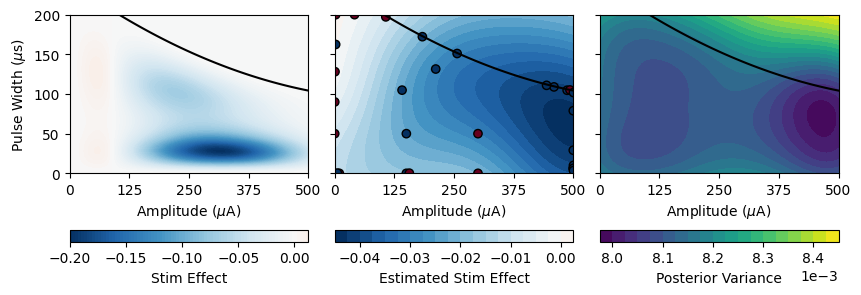

In [170]:
with open('outcomes/outcomes_eg_2.pickle', 'rb') as handle:
    results = pickle.load(handle)
ind = 7
sim = sims_full[127]
fig = plt.figure(figsize=(8.5, 8.5/3), layout='constrained')
ax0 = fig.add_subplot(131)
cbar0 = plot_ground_truth(sim, param_range, orientation='horizontal')
cbar0.ax.set_xticks([-0.2,-0.15,-0.1,-0.05,0])
plt.xticks([0, 125, 250, 375, 500])
plt.yticks([0,50,100,150,200])
ax = fig.add_subplot(132)
outcome = results[ind]
model = SingleTaskGP(outcome['model'].train_inputs[0][:30,:], torch.unsqueeze(outcome['model'].train_targets[:30], dim=1), torch.ones((30, 1)))
model.load_state_dict(outcome['hyperparams'][-1])
cbar = posterior_plot(ax, bounds, model, model.train_inputs[0], model.train_targets, alpha=False, edge=True, orientation='horizontal')
x = np.linspace(0,500,100)
plt.plot(x, (x - sim['saf_h']) ** 2 / sim['saf_a'] + sim['saf_k'], color='black')
cbar.ax.set_xticks([-0.04, -0.03, -0.02, -0.01, 0])
plt.xticks([0, 125, 250, 375, 500])
plt.yticks([0,50,100,150,200])
plt.ylim([0,200])
ax.set_yticklabels([])
plt.ylabel('')
ax2 = fig.add_subplot(133)
cbar2 = posterior_plot(ax2, bounds, model, model.train_inputs[0],model.train_targets, std=True, scatter=False, orientation='horizontal')
cbar2.ax.set_xticks([0.008, 0.0081, 0.0082, 0.0083, 0.0084])
cbar2.formatter.set_powerlimits((0, 0))
plt.plot(x, (x - sim['saf_h']) ** 2 / sim['saf_a'] + sim['saf_k'], color='black')
plt.xticks([0, 125, 250, 375, 500])
plt.yticks([0,50,100,150,200])
plt.ylim([0,200])
ax2.set_yticklabels([])
plt.ylabel('')

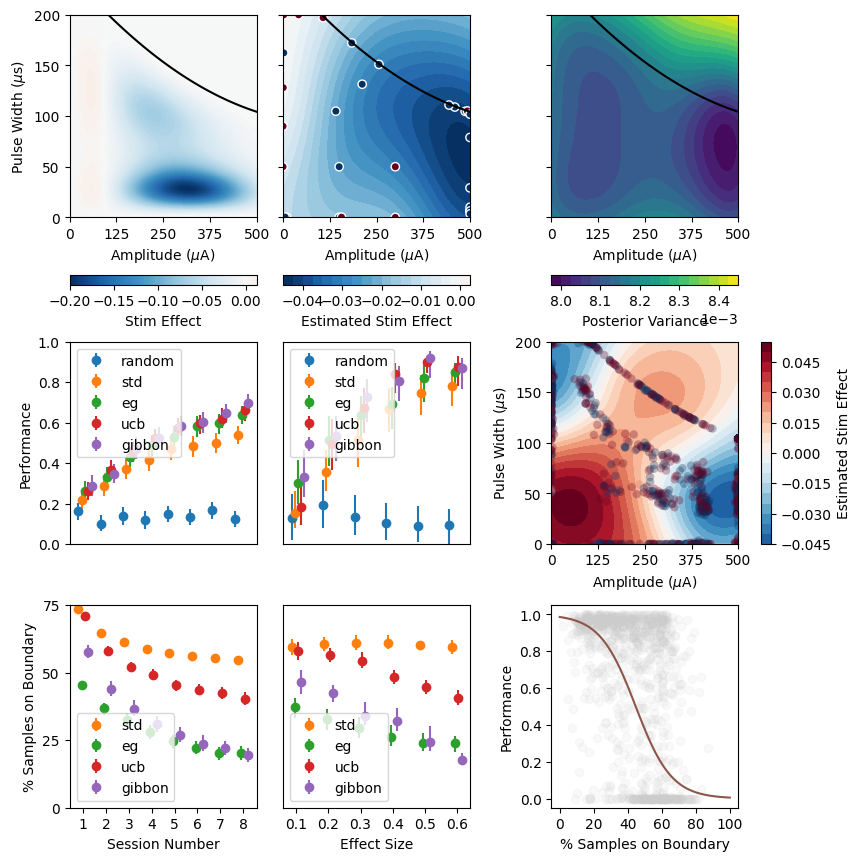

In [173]:
sims_full = []
with open('sims_100_01-06.pickle', 'rb') as handle:
    sims_full += pickle.load(handle)
with open('sims_100_01-06_2.pickle', 'rb') as handle:
    sims_full += pickle.load(handle)

plt.rcParams['svg.fonttype'] = 'none'
full_fig = plt.figure(figsize=(8.5, 8.5), layout='constrained')

sim = sims_full[127]
ax1 = full_fig.add_subplot(331)
cbar0 = plot_ground_truth(sim, param_range, orientation='horizontal')
cbar0.ax.set_xticks([-0.2,-0.15,-0.1,-0.05,0])
plt.xticks([0, 125, 250, 375, 500])
plt.yticks([0,50,100,150,200])

with open('outcomes/outcomes_eg_2.pickle', 'rb') as handle:
    results = pickle.load(handle)
    
ax2 = full_fig.add_subplot(332)
outcome = results[ind]
model = SingleTaskGP(outcome['model'].train_inputs[0][:30,:], torch.unsqueeze(outcome['model'].train_targets[:30], dim=1), torch.ones((30, 1)))
model.load_state_dict(outcome['hyperparams'][-1])
cbar = posterior_plot(ax2, bounds, model, model.train_inputs[0], model.train_targets, alpha=False, edge=True, orientation='horizontal')
x = np.linspace(0,500,100)
plt.plot(x, (x - sim['saf_h']) ** 2 / sim['saf_a'] + sim['saf_k'], color='black')
cbar.ax.set_xticks([-0.04, -0.03, -0.02, -0.01, 0])
plt.xticks([0, 125, 250, 375, 500])
plt.yticks([0,50,100,150,200])
plt.ylim([0,200])
ax2.set_yticklabels([])
plt.ylabel('')

ax3 = full_fig.add_subplot(333)
cbar2 = posterior_plot(ax3, bounds, model, model.train_inputs[0],model.train_targets, std=True, scatter=False, orientation='horizontal')
cbar2.ax.set_xticks([0.008, 0.0081, 0.0082, 0.0083, 0.0084])
cbar2.formatter.set_powerlimits((0, 0))
plt.plot(x, (x - sim['saf_h']) ** 2 / sim['saf_a'] + sim['saf_k'], color='black')
plt.xticks([0, 125, 250, 375, 500])
plt.yticks([0,50,100,150,200])
plt.ylim([0,200])
ax3.set_yticklabels([])
plt.ylabel('')

ax4 = plt.subplot(3,3,4)
acqfs = ['random', 'std', 'eg', 'ucb', 'gibbon']
effect_sizes = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
for i, acq in enumerate(acqfs):
    with open(f'outcomes/performance_{acq}.pickle', 'rb') as handle:
        performance = pickle.load(handle)
    perf_mat = np.asarray(performance)
    j = 2
    while os.path.isfile(f'outcomes/performance_{acq}_{j}.pickle'):
        with open(f'outcomes/performance_{acq}_{j}.pickle', 'rb') as handle:
            perf_mat = np.concatenate((perf_mat, np.asarray(pickle.load(handle))), axis=0)
        j += 1
    m_c = np.mean(perf_mat, axis=0)
    l_c = np.zeros_like(m_c)
    h_c = np.zeros_like(m_c)
    for j in range(perf_mat.shape[1]):
        res = bootstrap((perf_mat[:,j],), np.mean, n_resamples=1000)
        l_c[j] = res.confidence_interval.low
        h_c[j] = res.confidence_interval.high
    plt.errorbar(np.arange(1,9) + (i - 2) * 0.15, m_c, yerr=(m_c - l_c, h_c-m_c), linestyle='none', marker='o')
plt.legend(acqfs, loc='upper left')
plt.ylabel('Performance')
plt.xticks([])
plt.ylim(0, 1)
plt.yticks([0,0.2,0.4,0.6,0.8,1])

ax5 = plt.subplot(3,3,5)
effect_sizes = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
for i, acq in enumerate(acqfs):
    with open(f'outcomes/performance_{acq}.pickle', 'rb') as handle:
        performance = pickle.load(handle)
    j = 2
    perf_mat = np.asarray(performance)
    while os.path.isfile(f'outcomes/performance_{acq}_{j}.pickle'):
        with open(f'outcomes/performance_{acq}_{j}.pickle', 'rb') as handle:
            perf_mat = np.concatenate((perf_mat, np.asarray(pickle.load(handle))), axis=0)
        j += 1
    conditions = perf_mat[:,-1].reshape((int(perf_mat.shape[0]/6), 6))
    m_c = np.mean(conditions, axis=0)
    l_c = np.zeros_like(m_c)
    h_c = np.zeros_like(m_c)
    for j in range(conditions.shape[1]):
        res = bootstrap((conditions[:,j],), np.mean, n_resamples=1000)
        l_c[j] = res.confidence_interval.low
        h_c[j] = res.confidence_interval.high
    plt.errorbar(effect_sizes + (i - 2) * 0.01 + 0.005, m_c, yerr=(m_c-l_c, h_c-m_c), linestyle='none', marker='o')
plt.legend(acqfs, loc='upper left')
plt.ylim(0, 1)
plt.yticks([])
plt.xticks([])

ax6 = plt.subplot(3,3,6)
ind = 7
with open('outcomes/outcomes_gibbon_2.pickle', 'rb') as handle:
    results = pickle.load(handle)
posterior_plot(ax6, bounds, results[ind]['model'], results[ind]['model'].train_inputs[0],
               results[ind]['model'].train_targets)
plt.xticks([0, 125, 250, 375, 500])
plt.yticks([0, 50, 100, 150, 200])

acqfs = ['std', 'eg', 'ucb', 'gibbon']
plt.gca()._get_lines.get_next_color()

ax7 = plt.subplot(3,3,7)
plt.gca()._get_lines.get_next_color()
for i, acq in enumerate(acqfs):
    with open(f'outcomes/outcomes_{acq}.pickle', 'rb') as handle:
        results = pickle.load(handle)
    j = 2
    while os.path.isfile(f'outcomes/outcomes_{acq}_{j}.pickle'):
        with open(f'outcomes/outcomes_{acq}_{j}.pickle', 'rb') as handle:
            results += pickle.load(handle)
        j += 1
    n_boundary_samples = np.zeros((len(results), 8))
    for j, (sim, res) in enumerate(zip(sims_full, results)):
        input = res['model'].train_inputs[0][6:,:]
        on_boundary = torch.any(input < 0.025, dim=1)
        on_boundary |= torch.abs(((input[:, 0] * 500 - sim['saf_h']) ** 2 / sim['saf_a'] + sim['saf_k']) - 200 * input[:, 1]) < 0.025
        boundary_mat = torch.reshape(on_boundary, (n_session, n_trial))
        n_boundary_samples[j, :] = torch.sum(boundary_mat, dim=1).detach().cpu().numpy() / n_trial * 100
    m_c = np.mean(n_boundary_samples, axis=0)
    l_c = np.zeros_like(m_c)
    h_c = np.zeros_like(m_c)
    for j in range(n_boundary_samples.shape[1]):
        res = bootstrap((n_boundary_samples[:,j],), np.mean, n_resamples=1000)
        l_c[j] = res.confidence_interval.low
        h_c[j] = res.confidence_interval.high
    plt.errorbar(np.arange(1,9) + (i - 2) * 0.15 + 0.075, m_c, yerr=(m_c - l_c, h_c-m_c), linestyle='none', marker='o')
plt.legend(acqfs, loc='lower left')
plt.xlabel('Session Number')
plt.ylabel('% Samples on Boundary')
plt.xticks(np.arange(1,9))
plt.ylim(0, 75)
plt.yticks([0,25,50,75])

ax8 = plt.subplot(3,3,8)
plt.gca()._get_lines.get_next_color()
for i, acq in enumerate(acqfs):
    with open(f'outcomes/outcomes_{acq}.pickle', 'rb') as handle:
        results = pickle.load(handle)
    j = 2
    while os.path.isfile(f'outcomes/outcomes_{acq}_{j}.pickle'):
        with open(f'outcomes/outcomes_{acq}_{j}.pickle', 'rb') as handle:
            results += pickle.load(handle)
        j += 1
    with open(f'outcomes/performance_{acq}.pickle', 'rb') as handle:
        performance = pickle.load(handle)
    j = 2
    perf_mat = np.asarray(performance)
    while os.path.isfile(f'outcomes/performance_{acq}_{j}.pickle'):
        with open(f'outcomes/performance_{acq}_{j}.pickle', 'rb') as handle:
            perf_mat = np.concatenate((perf_mat, np.asarray(pickle.load(handle))), axis=0)
        j += 1
    n_boundary_samples = np.zeros((len(results) // len(effect_sizes), len(effect_sizes)))
    for j, (sim, res) in enumerate(zip(sims_full, results)):
        input = res['model'].train_inputs[0]
        on_boundary = torch.any(input < 0.025, dim=1)
        on_boundary |= torch.abs(((input[:, 0] * 500 - sim['saf_h']) ** 2 / sim['saf_a'] + sim['saf_k']) - 200 * input[:, 1]) < 0.025
        n_boundary_samples[j // len(effect_sizes), j % len(effect_sizes)] = torch.sum(on_boundary).detach().cpu().numpy() / on_boundary.shape[0] * 100
    m_c = np.mean(n_boundary_samples, axis=0)
    l_c = np.zeros_like(m_c)
    h_c = np.zeros_like(m_c)
    for j in range(n_boundary_samples.shape[1]):
        res = bootstrap((n_boundary_samples[:,j],), np.mean, n_resamples=1000)
        l_c[j] = res.confidence_interval.low
        h_c[j] = res.confidence_interval.high
    plt.errorbar(effect_sizes + (i - 2) * 0.01 + 0.005, m_c, yerr=(m_c - l_c, h_c-m_c), linestyle='none', marker='o')
plt.legend(acqfs, loc='lower left')
plt.xlabel('Effect Size')
plt.ylim(0, 75)
plt.yticks([])
plt.xticks(effect_sizes)

ax9 = plt.subplot(3,3,9)
results = []
n_boundary_samples = np.zeros(len(acqfs) * 120 * 2)
performance = np.zeros_like(n_boundary_samples)
for i, acq in enumerate(acqfs):
    with open(f'outcomes/outcomes_{acq}.pickle', 'rb') as handle:
        results += pickle.load(handle)
    j = 2
    while os.path.isfile(f'outcomes/outcomes_{acq}_{j}.pickle'):
        with open(f'outcomes/outcomes_{acq}_{j}.pickle', 'rb') as handle:
            results += pickle.load(handle)
        j += 1
    with open(f'outcomes/performance_{acq}.pickle', 'rb') as handle:
        perf = pickle.load(handle)
        perf_mat = np.asarray(perf)
        performance[i * 240 : i*240 + 120] = perf_mat[:, -1]
    j = 2
    while os.path.isfile(f'outcomes/performance_{acq}_{j}.pickle'):
        with open(f'outcomes/performance_{acq}_{j}.pickle', 'rb') as handle:
            perf = pickle.load(handle)
            perf_mat = np.asarray(perf)
            performance[i * 240 + (j-1) * 120: i*240 + j*120] = perf_mat[:, -1]
        j += 1
for j, res in enumerate(results):
    sim = sims_full[j % 240]
    input = res['model'].train_inputs[0]
    on_boundary = torch.any(input < 0.025, dim=1)
    on_boundary |= torch.abs(((input[:, 0] * 500 - sim['saf_h']) ** 2 / sim['saf_a'] + sim['saf_k']) - 200 * input[:, 1]) < 0.025
    n_boundary_samples[j] = torch.sum(on_boundary).detach().cpu().numpy() / on_boundary.shape[0] * 100
temp = performance
e = 1e-4
temp[temp > 1 - e] = 1 - e
temp[temp < e] = e
plt.scatter(n_boundary_samples, temp, color=[0.8,0.8,0.8], alpha=0.1)
temp = np.log(temp / (1-temp))
model2 = sm.OLS(temp, np.stack((np.ones_like(n_boundary_samples), n_boundary_samples), axis=1))
result2 = model2.fit()

pts = np.linspace(0, 100, 100)
plt.plot(pts, np.exp(result2.params[0] + result2.params[1] * pts) / (1 + np.exp(result2.params[0] + result2.params[1] * pts)), color=plt.rcParams['axes.prop_cycle'].by_key()['color'][5])
plt.xlabel('% Samples on Boundary')
plt.ylabel('Performance')
plt.yticks([0,0.2,0.4,0.6,0.8,1])
plt.xticks([0,20,40,60,80,100])
plt.savefig('figures/figure2.svg')